# Lesson 8: Decisions

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/master/notebooks/08_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- More Bayesian analysis examples
- Real-world data analysis in teams
- Intro to cognitive models


## The Mind as a Black Box

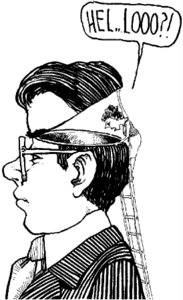

- Stuff comes in, behaviors come out...
- But what's going on in the box?

## Decisions as an important and accessible cognitive process

- Although we could try and open the box for all sorts of cognitive behaviors (e.g., perception, memory, etc...), decision making is a pervasive aspect of our lives.

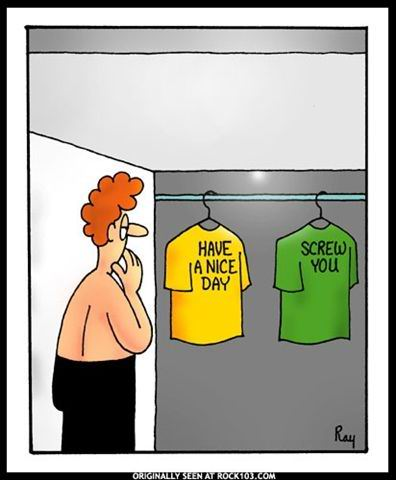

- What are some examples of decisions we make?


## How do we study decisions?

- What food would you rather eat?
- What direction are these dots moving?

## Questions we ask about decisions

- What choice did you make?
- How quickly did you make it?

## Example: Speed--Accuracy trade-off

- Sometimes we have to make fast decisions
- Other times we just need to be as accurate as possible.

## *ONLY* if on Google Colab

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git


In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/master/notebooks/decision_data.csv

In [ ]:
# to install plotnine (and fix statsmodels on Colab)
!pip install plotnine
!pip install statsmodels -U

In [94]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import plotnine as pn

from RunDEMC.density import kdensity

## Load and process the data

In [72]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)
dat = dat[dat.cond != 'Neutral']
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


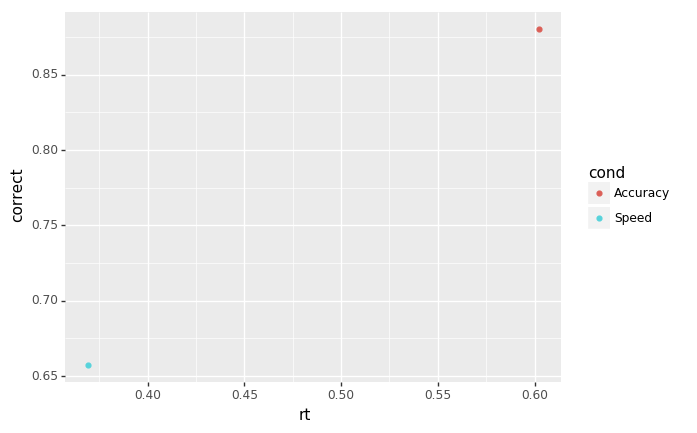

<ggplot: (8735531615289)>

In [73]:
# show trade-off between speed and accuracy
df = dat.groupby(['cond'])['rt','correct'].mean().reset_index()
pn.ggplot(df, pn.aes('rt', 'correct', color='cond')) + pn.geom_point()

## What does this tell us?

- Looking at behavioral effects alone can not reveal the processes that gave rise to that choice and RT.

- i.e., if you made a specific response, we don't know *why* you made that response.

## Going Deeper: What affects your decisions? 


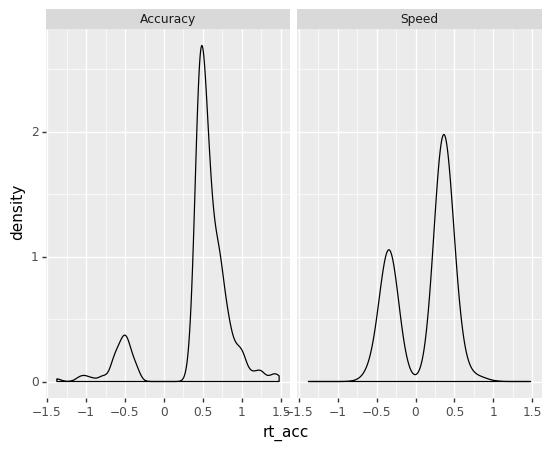

<ggplot: (8735530696396)>

In [81]:
# Plot the reaction time distributions
pn.ggplot(dat, pn.aes('rt_acc')) + pn.geom_density() + pn.facet_wrap('~cond')

## What is a computational model? 

- Take processes and instantiate them within a set of equations and explicit rules for how they interact.

## Linear Ballistic Accumlator (LBA)

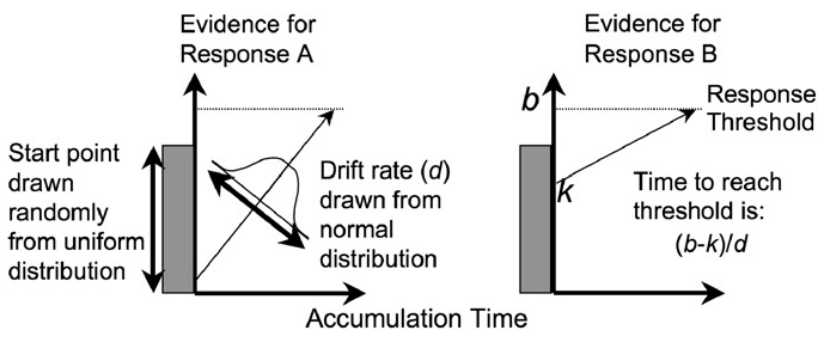

In [82]:
def lba_sim(I=(1.0,1.5), A=.1, S=1.0, b=1.0, num_sims=1000,
            max_time=2., t0=0.0, **kwargs):
    # set drift rate from inputs
    dr = np.float64(I)
    
    # set the number of choices
    nc = len(dr)
    
    # pick starting points
    k = np.random.uniform(0.,A,(num_sims,nc))
    
    # pick drifts
    # must make sure at least one d is greater than zero for each sim
    d = np.random.normal(dr,S,(num_sims,nc))
    # see where there are none above zero
    ind = np.all(d<=0.0,axis=1)
    while np.any(ind):
        d[ind,:] = np.random.normal(dr,S,(ind.sum(),nc))
        ind = np.all(d<=0.0,axis=1)

    # clip it to avoid divide by zeros
    d[d<=0.0] = np.finfo(dr.dtype).eps

    # calc the times for each
    t = (b-k)/d

    # see the earliest for each resp
    inds = t.argmin(1)
    times = t.take(inds+np.arange(t.shape[0])*t.shape[1])

    # process into choices
    times += t0

    # get valid responses
    resp_ind = times < (max_time)
    rts = []
    for i in range(nc):
        rt = times[resp_ind & (inds==i)]
        rts.append(rt)

    return rts



In [121]:
# set up the sim
nsims = 5000
cond='Accuracy'
ndat = (dat['cond']==cond).sum()

# normed histogram
def dhist(dat, nsims, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nsims
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)

# normed pdf
xvals = np.linspace(0.1,2.0,100)
def dplot(dat, nsims, color='b', lw=2.):
    p,xx = kdensity(dat, extrema=(xvals.min(),xvals.max()), xx=xvals)
    p *= float(len(dat))/nsims
    plt.plot(xx, p, color=color, lw=2.)

# put it all together
def run_lba(d1=1.0, d2=2.0, A=.1, b=1.0, t0=0.0):
    # run the LBA model
    res = lba_sim(I=(d1, d2), A=A, S=1.0, b=b, num_sims=nsims, max_time=2.0, t0=t0)

    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    dplot(res[1], nsims, color='b')
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    dplot(res[0], nsims, color='r')
    #ylim(0,5.0)
    plt.xlim(0,2.0)

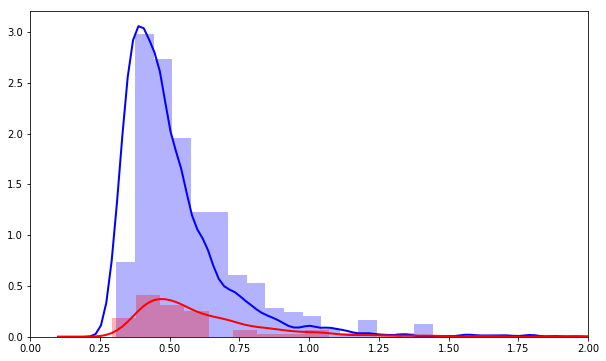

In [122]:
# set up new figure
plt.figure(figsize=(10,6))

# try different params!
d1 = 1.0   # drift for incorrect between 0 and 5
d2 = 2.5   # drift for correct between 0 and 5
A = 0.1    # starting point range between 0 and 1
b = 1.0    # thresh between 0 and 5
t0 = 0.10   # non-decision time between 0 and 1

# call the function
run_lba(d1=d1, d2=d2, A=A, b=b, t0=t0)

## Using computers to test hypotheses

In [106]:
from RunDEMC import Model, Param, dists

In [113]:
# Test change in threshold

# set up the params
params = [Param(name='d1', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='b_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.trunc_normal(.2, 1.0, 0., 1.0))]

# grab the beh data of interest
dat_A_1 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==0)]['rt'])
dat_A_2 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==1)]['rt'])
num_A = float((dat['cond']=='Accuracy').sum())
prop_A_1 = len(dat_A_1)/num_A
prop_A_2 = len(dat_A_2)/num_A
dat_S_1 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==0)]['rt'])
dat_S_2 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==1)]['rt'])
num_S = float((dat['cond']=='Speed').sum())
prop_S_1 = len(dat_S_1)/num_S
prop_S_2 = len(dat_S_2)/num_S

# define the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p[2] > p[3]) or (p[2] > p[4]) or np.any(p<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        res = lba_sim(I=(p[0], p[1]), A=p[2], S=1.0, b=p[3], num_sims=nsims, max_time=2.0, t0=p[5])
        
        # process first response
        if len(res[0])>2:
            pp,xx = kdensity(res[0], extrema=(0,2.0), xx=dat_A_1)
            pp *= float(len(res[0]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        if len(res[1])>2:
            pp,xx = kdensity(res[1], extrema=(0,2.0), xx=dat_A_2)
            pp *= float(len(res[1]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # then Speed
        res = lba_sim(I=(p[0], p[1]), A=p[2], S=1.0, b=p[4], num_sims=nsims, max_time=2.0, t0=p[5])
        
        # process first response
        if len(res[0])>2:
            pp,xx = kdensity(res[0], extrema=(0,2.0), xx=dat_S_1)
            pp *= float(len(res[0]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        if len(res[1])>2:
            pp,xx = kdensity(res[1], extrema=(0,2.0), xx=dat_S_2)
            pp *= float(len(res[1]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue

    return likes
        
# make the model
m = Model('decisions', params=params,
          like_fun=like_fun,
          like_args=(dat,),
          purify_every=5,
          verbose=True)

# do some burnin
times = m.sample(25, burnin=True)

Initializing: 60(60) 

/home/per/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
/home/per/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/per/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
/home/per/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


52(52) 46(46) 38(38) 38(38) 34(34) 32(32) 26(26) 23(23) 20(20) 18(18) 13(13) 13(13) 11(11) 8(8) 7(7) 6(6) 5(5) 4(4) 4(4) 4(4) 4(4) 4(4) 3(3) 2(2) 2(2) 1(1) 1(1) 1(1) 1(1) 1(1) Iterations (25): 1 2 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


3 4 = 5 6 7 8 9 = 10 11 12 13 14 = 15 16 17 18 19 = 20 21 22 23 24 = 25 


In [117]:
times = m.sample(25, burnin=True)

Iterations (25): 1 2 3 4 = 5 6 7 8 9 = 10 11 12 13 14 = 15 16 17 18 19 = 20 21 22 23 24 = 25 


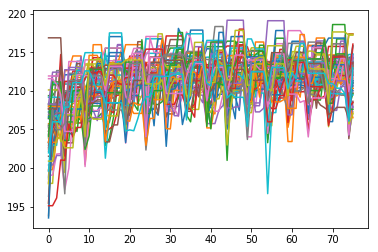

In [118]:
plt.plot(m.weights[25:]);

In [120]:
print("Best fitting params:")
burnin=5
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 210.27682529062423
"d1": 1.420700,
"d2": 2.497676,
"A": 0.488168,
"b_A": 1.186246,
"b_S": 0.694646,
"t0": 0.198309,


/home/per/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


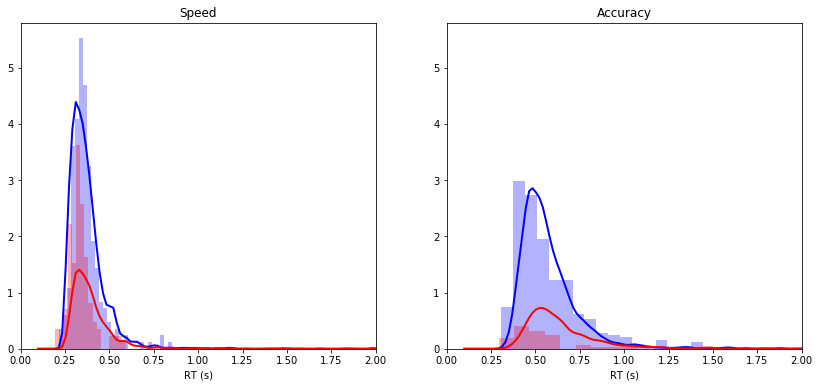

In [127]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res[1], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res[0], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res[1], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res[0], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

In [132]:
# Test change in drift rate

# set up the params
params = [Param(name='d1_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d1_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.trunc_normal(.2, 1.0, 0., 1.0))]

# grab the beh data of interest
dat_A_1 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==0)]['rt'])
dat_A_2 = np.array(dat[(dat['cond']=='Accuracy')&(dat['correct']==1)]['rt'])
num_A = float((dat['cond']=='Accuracy').sum())
prop_A_1 = len(dat_A_1)/num_A
prop_A_2 = len(dat_A_2)/num_A
dat_S_1 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==0)]['rt'])
dat_S_2 = np.array(dat[(dat['cond']=='Speed')&(dat['correct']==1)]['rt'])
num_S = float((dat['cond']=='Speed').sum())
prop_S_1 = len(dat_S_1)/num_S
prop_S_2 = len(dat_S_2)/num_S

# set up the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p[4] > p[5]) or np.any(p<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        res = lba_sim(I=(p[0], p[1]), A=p[4], S=1.0, b=p[5], 
                      num_sims=nsims, max_time=2.0, t0=p[6])
        
        # process first response
        if len(res[0])>2:
            pp,xx = kdensity(res[0], extrema=(0,2.0), xx=dat_A_1)
            pp *= float(len(res[0]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        if len(res[1])>2:
            pp,xx = kdensity(res[1], extrema=(0,2.0), xx=dat_A_2)
            pp *= float(len(res[1]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # then Speed
        res = lba_sim(I=(p[2], p[3]), A=p[4], S=1.0, b=p[5], 
                      num_sims=nsims, max_time=2.0, t0=p[6])
        
        # process first response
        if len(res[0])>2:
            pp,xx = kdensity(res[0], extrema=(0,2.0), xx=dat_S_1)
            pp *= float(len(res[0]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue
        
        # process second response
        if len(res[1])>2:
            pp,xx = kdensity(res[1], extrema=(0,2.0), xx=dat_S_2)
            pp *= float(len(res[1]))/nsims
            likes[i] += np.log(pp).sum()
        else:
            likes[i] = -np.inf
            continue

    return likes
        
# make the model
m = Model('decisions2', params=params,
          like_fun=like_fun,
          like_args=(dat,),
          purify_every=5,
          verbose=True)

# do some burnin
times = m.sample(25, burnin=True)

Initializing: 70(70) 

/home/per/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/home/per/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log
/home/per/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log
/home/per/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


62(62) 48(48) 34(34) 31(31) 26(26) 21(21) 16(16) 14(14) 11(11) 9(9) 7(7) 4(4) 4(4) 3(3) 3(3) 2(2) 1(1) 1(1) Iterations (25): 1 2 3 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


4 = 5 6 7 8 9 = 10 11 12 13 14 = 15 16 17 18 19 = 20 21 22 23 24 = 25 


In [135]:
times = m.sample(25, burnin=True)

Iterations (25): 1 2 

/home/per/Nextcloud/proj/RunDEMC/RunDEMC/demc.py:625: RuntimeWarning: divide by zero encountered in log
  log_pdf = np.log(param.prior.pdf(p))


3 4 

/home/per/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


= 5 6 7 8 9 = 10 11 12 13 14 = 15 16 17 18 19 = 20 21 22 23 24 = 25 


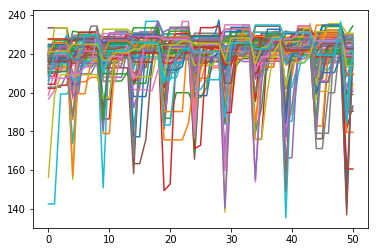

In [136]:
plt.plot(m.weights[25:]);

In [137]:
print("Best fitting params:")
burnin=5
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 223.99696797576664
"d1_A": 1.430031,
"d2_A": 2.800807,
"d1_S": 3.779471,
"d2_S": 4.218724,
"A": 0.231136,
"b": 1.667426,
"t0": 0.026121,


/home/per/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


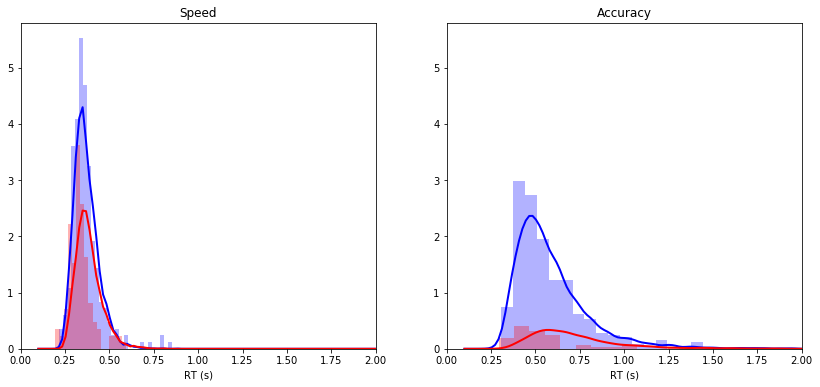

In [138]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res[1], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res[0], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(res[1], nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(res[0], nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);